In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
data = pd.read_excel('co-op dataset.xlsx')

# Display the dataframe
print(data)

          ID WEEK_END_DT  TOTAL_DISPENSED  FLAVORED_DISPENSED
0    743BD6E  2022-07-10         278418.0         60878.00000
1    1CD19D3  2022-07-10          28045.0         10517.00004
2    D3635AD  2022-07-10          23631.0         16203.99998
3    A74A256  2022-07-10              NaN                 NaN
4    BB7EA2A  2022-07-10         132980.0         79995.00001
..       ...         ...              ...                 ...
350  FBCE7D2  2023-10-01          18096.0          6573.00001
351  1CD19D3  2023-10-01              NaN                 NaN
352  D3635AD  2023-10-01         143329.0         45258.00001
353  A74A256  2023-10-01          80881.0         29208.99999
354  BB7EA2A  2023-10-01         179271.0         52692.99997

[355 rows x 4 columns]


In [3]:
# Check for missing values
print(data.isnull().sum())

ID                     0
WEEK_END_DT            0
TOTAL_DISPENSED       43
FLAVORED_DISPENSED    43
dtype: int64


In [4]:
# Clean up column names by stripping any leading/trailing spaces
data.columns = data.columns.str.strip()

# Rename columns for consistency and clarity
data.rename(columns={'ID': 'machine_id', 'WEEK_END_DT': 'week_end_date', 'TOTAL_DISPENSED': 'total_dispensed', 'FLAVORED_DISPENSED': 'flavored_dispensed'}, inplace=True)

# Convert the date column to datetime
data['week_end_date'] = pd.to_datetime(data['week_end_date'])

# Display the first few rows of the dataset
print(data.head())
print(data.info())


  machine_id week_end_date  total_dispensed  flavored_dispensed
0    743BD6E    2022-07-10         278418.0         60878.00000
1    1CD19D3    2022-07-10          28045.0         10517.00004
2    D3635AD    2022-07-10          23631.0         16203.99998
3    A74A256    2022-07-10              NaN                 NaN
4    BB7EA2A    2022-07-10         132980.0         79995.00001
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   machine_id          355 non-null    object        
 1   week_end_date       355 non-null    datetime64[ns]
 2   total_dispensed     312 non-null    float64       
 3   flavored_dispensed  312 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 11.2+ KB
None


In [5]:
# Function to fill missing values based on the median of each machine
def fill_missing_values(group):
    group['total_dispensed'].fillna(group['total_dispensed'].median(), inplace=True)
    group['flavored_dispensed'].fillna(group['flavored_dispensed'].median(), inplace=True)
    return group

# Apply the function to each machine group
data = data.groupby('machine_id').apply(fill_missing_values).reset_index(drop=True)

# Check for any remaining missing values
print(data.isnull().sum())


machine_id            0
week_end_date         0
total_dispensed       0
flavored_dispensed    0
dtype: int64


In [6]:
# Add week number and month as features
data['week_number'] = data['week_end_date'].dt.isocalendar().week
data['month'] = data['week_end_date'].dt.month

# Remove potential outliers (values that are significantly higher or lower than the rest)
def remove_outliers(group):
    Q1 = group['total_dispensed'].quantile(0.25)
    Q3 = group['total_dispensed'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['total_dispensed'] >= lower_bound) & (group['total_dispensed'] <= upper_bound)]

data = data.groupby('machine_id').apply(remove_outliers).reset_index(drop=True)

# Display the first few rows of the data with new features
print(data.head())


  machine_id week_end_date  total_dispensed  flavored_dispensed  week_number  \
0    1CD19D3    2022-10-09           8293.0              3673.0           40   
1    1CD19D3    2023-02-05           8293.0              2318.0            5   
2    1CD19D3    2023-02-12           8293.0              2318.0            6   
3    1CD19D3    2023-02-19           8293.0              2318.0            7   
4    1CD19D3    2023-02-26           8293.0              2318.0            8   

   month  
0     10  
1      2  
2      2  
3      2  
4      2  


In [7]:
# Train-Test Split
train_data = data[data['week_end_date'] <= '2023-06-30']
test_data = data[(data['week_end_date'] > '2023-06-30') & (data['week_end_date'] <= '2023-09-30')]

In [11]:
# Forecasting function using SARIMA
def sarima_forecast(train, test, order=(1,1,1), seasonal_order=(1,1,1,52)):
    forecasts = []
    actuals = []
    for machine_id in train['machine_id'].unique():
        machine_train = train[train['machine_id'] == machine_id]
        machine_test = test[test['machine_id'] == machine_id]
        
        model = SARIMAX(machine_train['total_dispensed'],
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        results = model.fit(disp=False)
        
        forecast = results.get_forecast(steps=len(machine_test))
        forecast_values = forecast.predicted_mean.values
        actual_values = machine_test['total_dispensed'].values
        
        forecasts.extend(forecast_values)
        actuals.extend(actual_values)
        
        plt.figure(figsize=(10, 6))
        plt.plot(machine_train['week_end_date'], machine_train['total_dispensed'], label='Train')
        plt.plot(machine_test['week_end_date'], machine_test['total_dispensed'], label='Test')
        plt.plot(machine_test['week_end_date'], forecast_values, label='Forecast')
        plt.title(f'Machine {machine_id} Usage Forecast')
        plt.legend()
        plt.show()
    
    return actuals, forecasts

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


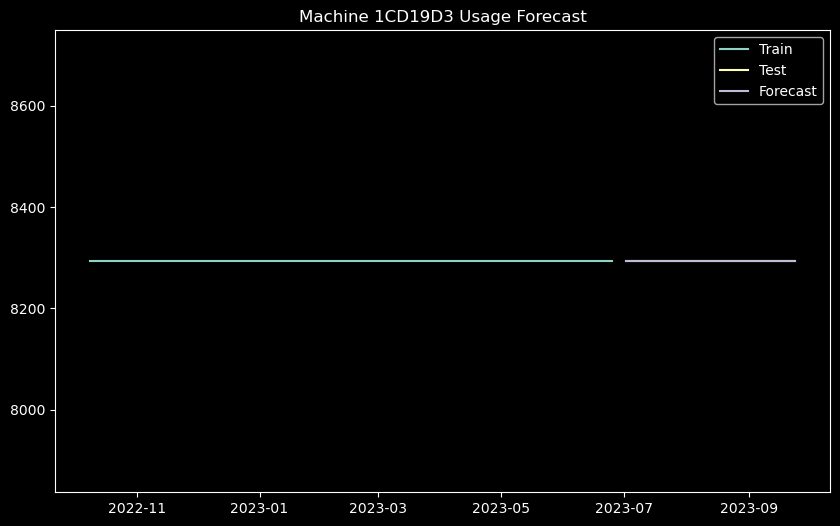

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal AR

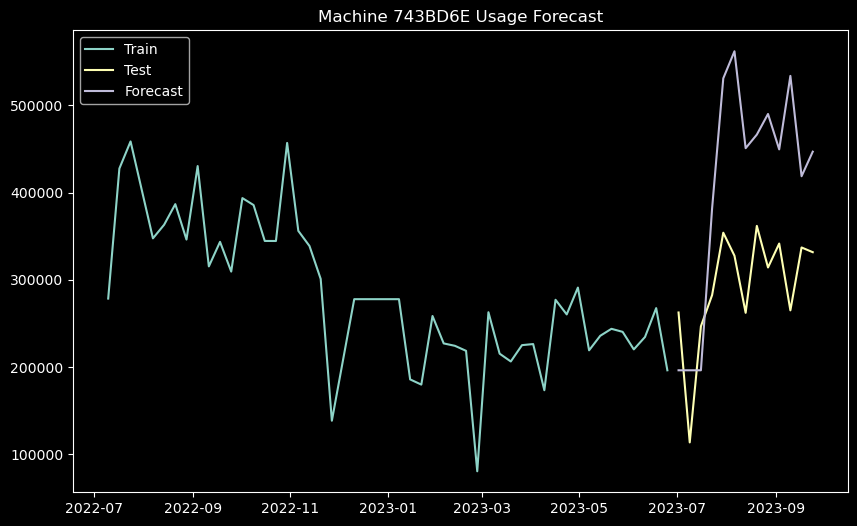

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal AR

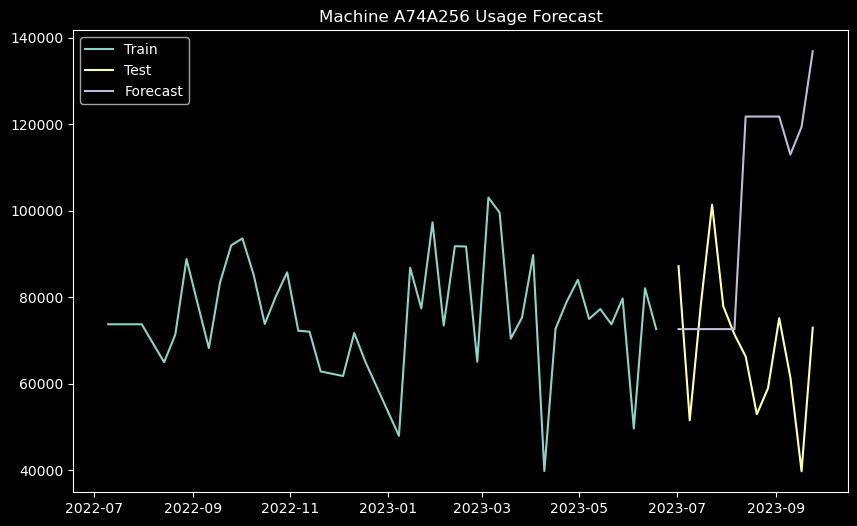

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal AR

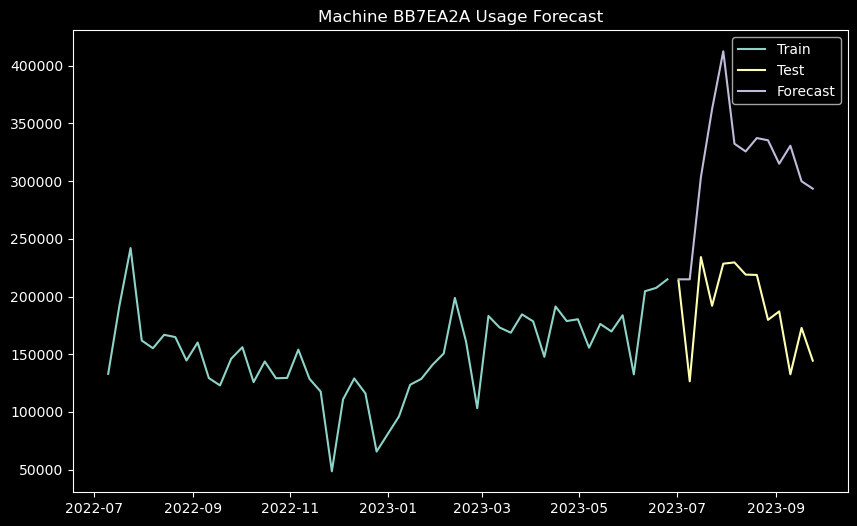

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal AR

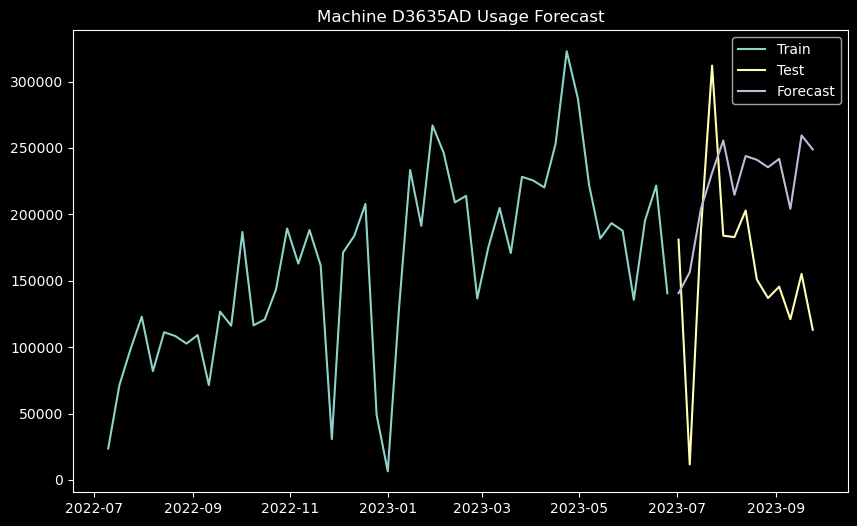

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal AR

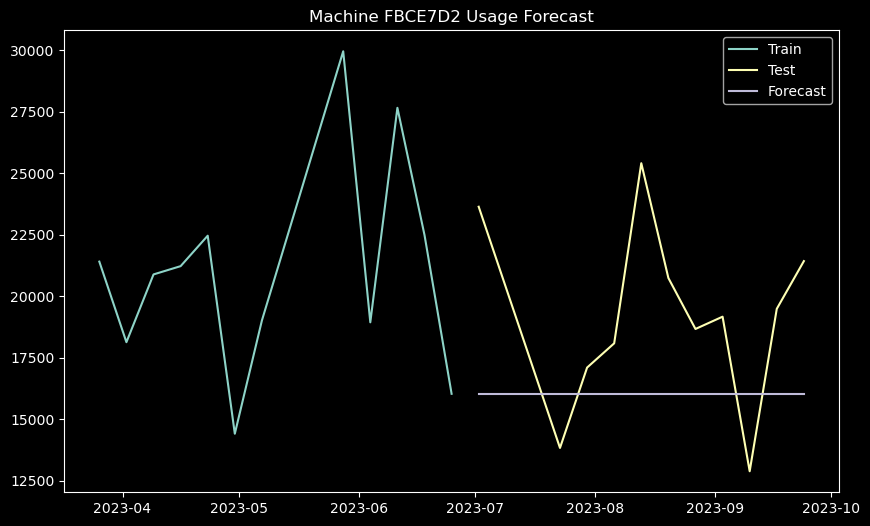

Mean Absolute Error: 65849.99999999993
Root Mean Squared Error: 93144.08762113305


In [9]:

# Run forecasting and calculate accuracy
actuals, forecasts = sarima_forecast(train_data, test_data)
mae = mean_absolute_error(actuals, forecasts)
rmse = np.sqrt(mean_squared_error(actuals, forecasts))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')